In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Pada bagian ini, kita mengimpor beberapa library penting yang akan digunakan dalam proyek ini. Library-library tersebut antara lain:
- pandas: Untuk manipulasi data dan analisis data dalam bentuk tabel (DataFrame).
- numpy: Untuk operasi numerik dan array.
- matplotlib.pyplot: Untuk visualisasi data dalam bentuk grafik atau plot.
- seaborn: Library berbasis matplotlib yang digunakan untuk membuat visualisasi data yang lebih interaktif dan menarik.
- sklearn.model_selection.train_test_split: Untuk membagi dataset menjadi data latih (train set) dan data uji (test set).
- sklearn.preprocessing.OneHotEncoder: Untuk melakukan encoding fitur kategorikal menjadi bentuk numerik agar dapat digunakan dalam model Machine Learning.
- sklearn.preprocessing.StandardScaler: Untuk melakukan scaling pada fitur numerik agar distribusi data lebih merata, yang bertujuan untuk meningkatkan performa model.
- sklearn.metrics: Untuk mengevaluasi performa model.
- mean_squared_error: Metrik untuk mengukur tingkat kesalahan pada model regresi.
- accuracy_score: Metrik untuk mengukur akurasi model pada kasus klasifikasi.
- classification_report: Menampilkan metrik evaluasi seperti precision, recall, f1-score pada kasus klasifikasi.
- confusion_matrix: Menampilkan confusion matrix pada kasus klasifikasi.

# Data Preparation

## Data Loading

In [2]:
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kangatomic69","key":"7bb5292f0532b3409ed4ba4851ff3fea"}'}

In [3]:
train_dt = pd.read_csv("https://raw.githubusercontent.com/symphonicragnir/Submisi_Dicoding_ProjectAkhirr_MLterapan/refs/heads/main/StudentsPerformance.csv")
train_dt.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Pada bagian ini, kita akan memuat dataset menggunakan library pandas. Dataset yang digunakan bernama `study_performance.csv`.
- `file_path`: Variabel yang menyimpan lokasi atau path dataset.
- `pd.read_csv()`: Fungsi untuk membaca file CSV dan mengonversinya menjadi objek DataFrame.

## Exploratory Data Analysis (EDA)

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtyp

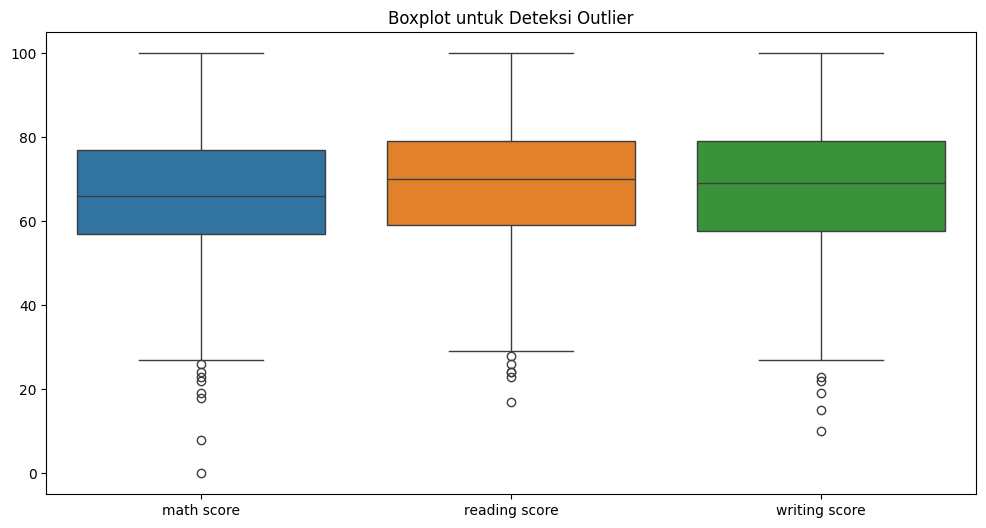

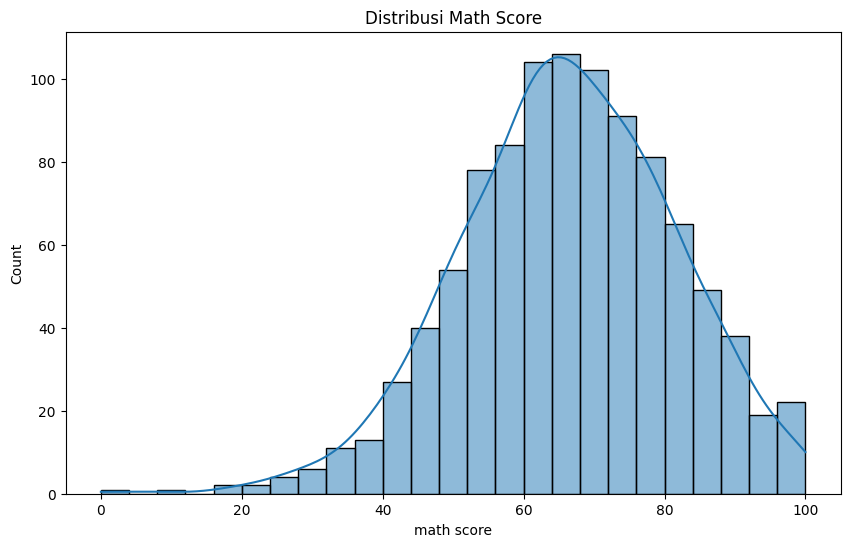

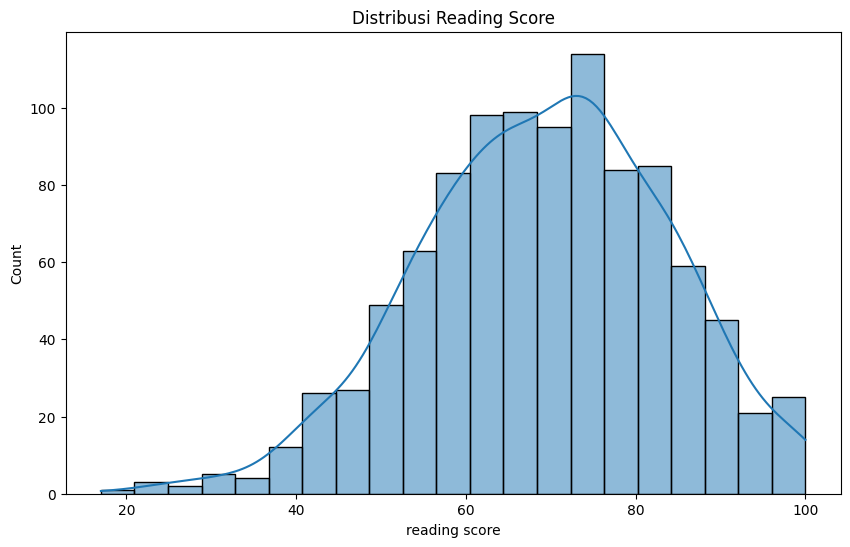

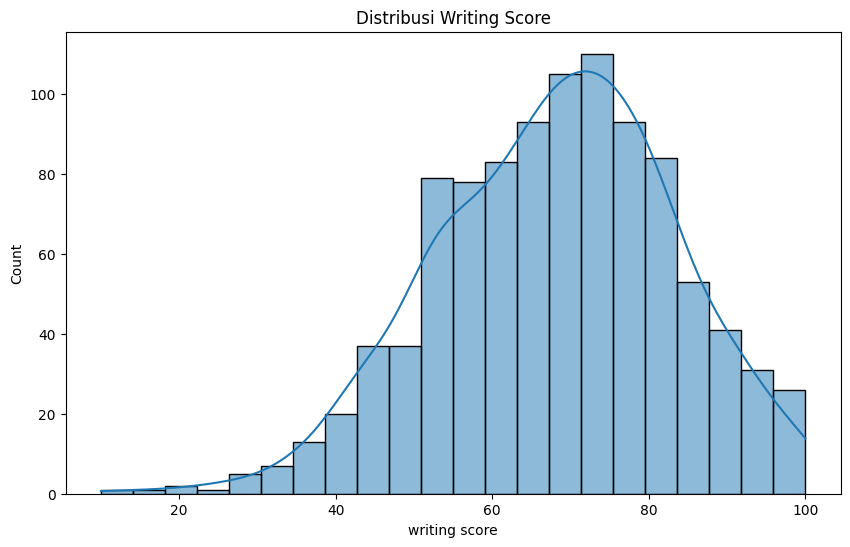

In [4]:
# Melihat 5 data teratas
print(train_dt.head())

# Informasi dataset
print(train_dt.info())

# Cek missing values
print(train_dt.isnull().sum())

# Statistik deskriptif
print(train_dt.describe())

#cek dupliksi data
print("duplikasi data : ", train_dt.duplicated().sum())

#visualisais outlier
plt.figure(figsize=(12, 6))
# Access the columns using their actual names from the DataFrame
sns.boxplot(data=train_dt[['math score', 'reading score', 'writing score']])
plt.title('Boxplot untuk Deteksi Outlier')
plt.show()


# Visualisasi distribusi skor matematika
plt.figure(figsize=(10, 6))
sns.histplot(train_dt['math score'], kde=True) # Corrected column name
plt.title('Distribusi Math Score')
plt.show()

# Visualisasi distribusi skor membaca
plt.figure(figsize=(10, 6))
sns.histplot(train_dt['reading score'], kde=True) # Corrected column name
plt.title('Distribusi Reading Score')
plt.show()

# Visualisasi distribusi skor menulis
plt.figure(figsize=(10, 6))
sns.histplot(train_dt['writing score'], kde=True) # Corrected column name
plt.title('Distribusi Writing Score')
plt.show()

1. Missing Values (Nilai Hilang):
    Dari hasil pengecekan menggunakan `data.isnull().sum()`, terlihat bahwa seluruh kolom memiliki nilai 0 untuk jumlah nilai hilang (missing values). Kesimpulannya, Dataset tidak memiliki missing values.
2. Duplikasi Data
    Dari hasil pengecekan menggunakan `data.duplicated().sum()`, terlihat bahwa tidak ada data yang duplikat.
3. Outlier Analysis:
    - Pada boxplot, terlihat beberapa titik yang berada di luar batas bawah (lower whisker) pada ketiga fitur numerik (`math_score`, `reading_score`, `writing_score`).
    - Titik-titik tersebut merupakan outlier karena berada di bawah batas Q1 - 1.5 * IQR.
    - Tidak ada outlier yang signifikan di bagian atas (upper whisker), hanya di bagian bawah.

berikut penjelasan hasil visualisasi distribusi skor:

1. Distribusi Math Score:
    Pada grafik ini, distribusi nilai matematika memiliki pola yang mendekati distribusi normal. Mayoritas nilai matematika berkisar antara 50 hingga 80, dengan puncak distribusi berada di sekitar nilai 60-70. Terdapat beberapa outlier di bagian kiri yang menunjukkan siswa dengan skor rendah (< 30), namun jumlahnya relatif sedikit.

2. Distribusi Reading Score:
    Distribusi nilai membaca juga menunjukkan pola mendekati normal, tetapi lebih condong ke kanan (skewed to the right). Puncak distribusi berada di sekitar nilai 70-80. Terdapat lebih banyak siswa yang mendapatkan skor tinggi (> 80) dibandingkan dengan siswa yang mendapatkan skor rendah (< 30).

3. Distribusi Writing Score:
    Distribusi skor menulis memiliki pola yang sangat mirip dengan skor membaca. Sebagian besar skor berkisar antara 60 hingga 80, dengan puncak distribusi di sekitar nilai 70-80. Grafik ini juga menunjukkan bahwa terdapat beberapa outlier di bagian bawah (skor rendah).

Secara keseluruhan, ketiga skor tersebut menunjukkan pola distribusi yang hampir simetris dan mendekati distribusi normal, meskipun terdapat sedikit skewness pada skor membaca dan menulis. Hal ini menunjukkan bahwa sebagian besar siswa mendapatkan skor yang cukup baik di ketiga kategori tersebut.


## Data Preparation

In [5]:
# Scaling fitur numerik
from sklearn.preprocessing import StandardScaler # Import StandardScaler
scaler = StandardScaler()
numeric_features = ['math score', 'reading score', 'writing score'] # Fix column names
train_dt[numeric_features] = scaler.fit_transform(train_dt[numeric_features])

Pada tahap ini, dilakukan proses standarisasi fitur numerik menggunakan `StandardScaler()` dari library sklearn. Standarisasi dilakukan untuk memastikan semua fitur numerik memiliki skala yang sama, sehingga tidak ada fitur yang mendominasi model hanya karena skala nilainya lebih besar.

Fitur-fitur numerik yang akan distandarisasi adalah:
- `math_score`
- `reading_score`
- `writing_score`

Proses standarisasi ini mengubah data menjadi distribusi dengan rata-rata 0 dan standar deviasi 1. Di sini, scaler.fit_transform() akan menghitung rata-rata dan standar deviasi dari data, lalu menerapkannya pada dataset. Setelah proses ini, data yang telah distandarisasi akan menggantikan data asli pada fitur math_score, reading_score, dan writing_score.

In [6]:
# Fitur numerik dan kategori
numeric_features = ['reading score', 'writing score'] # Use correct column names
categorical_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']  # Fixed: Column names

# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# OneHot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(train_dt[categorical_features])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

# Gabungkan data numerik dan hasil encoding
X = pd.concat([train_dt[numeric_features], encoded_categorical_df], axis=1)
y = train_dt['math score']  # Fixed: Column name

# Pembagian data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Pada tahap ini, dilakukan beberapa proses untuk mempersiapkan data sebelum dilakukan pemodelan:

1. Identifikasi Fitur Numerik dan Kategori:
    - Fitur numerik (`numeric_features`): `reading_score` dan `writing_score`.
    - Fitur kategori (`categorical_features`): `gender`, `race_ethnicity`, `parental_level_of_education`, `lunch`, dan `test_preparation_course`.

2. OneHot Encoding:
    - Fitur kategori dikonversi menjadi bentuk numerik menggunakan `OneHotEncoder` dari sklearn.
    - Parameter `drop='first'` digunakan untuk menghindari dummy variable trap dengan menghapus kategori pertama.
    - Parameter `sparse_output=False` digunakan agar hasil encoding berupa DataFrame, bukan Sparse Matrix.

3. Menggabungkan Data Numerik dan Hasil Encoding:
    - Data numerik dan hasil encoding digabungkan menggunakan `pd.concat()`.

4. Pembagian Data:
    - Fitur (X): Gabungan data numerik (`reading_score`, `writing_score`) dan hasil OneHot Encoding.
    - Target (y): `math_score`, yaitu skor matematika siswa yang akan diprediksi.
    - Data dibagi menjadi data latih (`X_train`, `y_train`) dan data uji (`X_test`, `y_test`) dengan proporsi 80:20 menggunakan `train_test_split()`.

Parameter `random_state=42` digunakan agar proses pembagian data tetap konsisten setiap kali kode dijalankan

## Modelling

In [7]:
# Simple Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Pada tahap ini, model Simple Linear Regression diterapkan sebagai baseline model untuk prediksi skor matematika (`math_score`).

- Library yang digunakan: `LinearRegression()` dari `sklearn.linear_model`.
- Proses fitting (`fit()`) dilakukan menggunakan data latih (`X_train`, `y_train`).
- Model akan belajar mencari hubungan linear antara fitur-fitur prediktor (`X_train`) dan target (`y_train`).

Model ini dipilih sebagai baseline karena kesederhanaannya dan untuk memberikan gambaran awal mengenai hubungan linear antara fitur prediktor dan skor matematika.

## Evaluasi dan Visualisasi

In [8]:
# Evaluasi
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error # Import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R²):', r2)

Mean Squared Error (MSE): 0.12667197758547108
Mean Absolute Error (MAE): 0.2781012880760493
R-squared (R²): 0.8804332983749564


Pada tahap ini, dilakukan proses evaluasi model Simple Linear Regression menggunakan tiga metrik utama:

1. Mean Squared Error (MSE):
    - MSE mengukur rata-rata dari kuadrat perbedaan antara nilai aktual (`y_test`) dan nilai prediksi (`y_pred`).
    - Nilai MSE yang lebih rendah menunjukkan bahwa model mampu menghasilkan prediksi yang mendekati nilai aktual.
    - Pada model ini, MSE adalah 0.1266.

2. Mean Absolute Error (MAE):
    - MAE mengukur rata-rata dari nilai absolut perbedaan antara nilai aktual dan prediksi.
    - Semakin kecil nilai MAE, semakin baik performa model.
    - Pada model ini, MAE adalah 0.2781.

3. R-squared (R²):
    - R² mengukur seberapa baik model dapat menjelaskan variasi data target (`y_test`).
    - Nilainya berkisar antara 0 hingga 1, di mana nilai mendekati 1 menunjukkan bahwa model memiliki kemampuan prediktif yang baik.
    - Pada model ini, R² adalah 0.8804, yang berarti model dapat menjelaskan sekitar 88% variabilitas data skor matematika.

## Visualisasi Hasil Prediksi vs Aktual

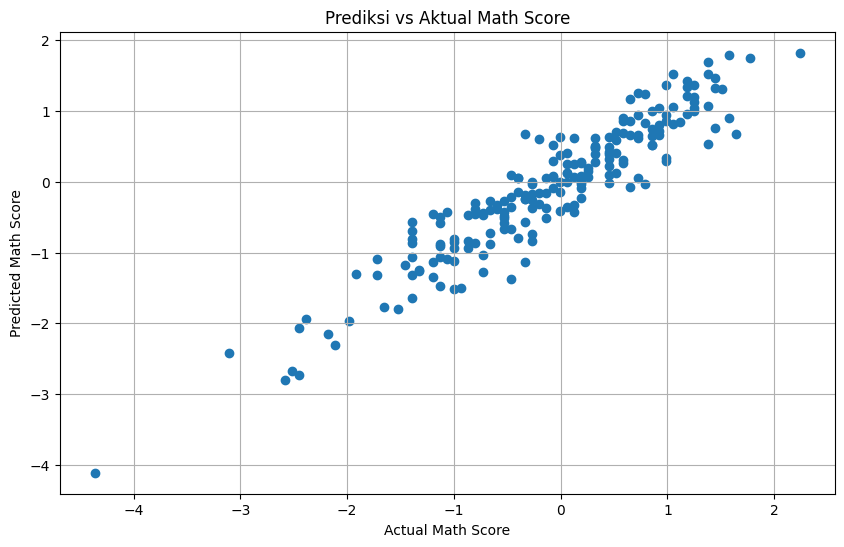

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Prediksi vs Aktual Math Score')
plt.grid()
plt.show()

Visualisasi ini menunjukkan hubungan antara nilai aktual (`y_test`) dan nilai prediksi (`y_pred`) untuk skor matematika (`math_score`).
- Sumbu X: Nilai aktual skor matematika.
- Sumbu Y: Nilai prediksi skor matematika.
- Scatter plot digunakan untuk melihat bagaimana model menangkap pola data. Jika titik-titik tersebut berada di sekitar garis diagonal (y = x), maka model berhasil melakukan prediksi yang akurat.
- Pada visualisasi ini, sebagian besar titik tersebar di sekitar garis diagonal, menunjukkan bahwa model dapat melakukan prediksi yang cukup baik meskipun terdapat beberapa outlier.

